## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest
import trajectory_msgs.msg
from copy import deepcopy


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:

rospy.init_node("recognition")


In [7]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_weighted')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)
scene = moveit_commander.PlanningSceneInterface()
scene.remove_world_object()

In [8]:
def add_object(name, size, pose, orientation):
    p = PoseStamped()
    p.header.frame_id = "odom"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

     
    p.pose.orientation.x = orientation[0] 
    p.pose.orientation.y = orientation[1] 
    p.pose.orientation.z = orientation[2] 
    p.pose.orientation.w = orientation[3]
    scene.add_box(name, p, size)



def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4],  [2.5, 4.85, 0.78],  [0.5,0,0,0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.85, 0.49], [0.5,0,0, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.85, 0.18], [0.5,0,0, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5,0,0, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5],[0.5,0,0, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5,0,0 ,0.5])    
    add_object("table_big", [1.5, 0.13, 0.5], [0.95, 1.9, 0.34],  [0.5,0,0, 0.5])
    add_object("table_big_legs1",[.01,.6,.2], [1.55,1.8,0.1],       [0.5,0,0, 0.5])
    add_object("table_big_legs2",[.01,.6,.2], [0.45,1.8,0.1],       [0.5,0,0 ,0.5])
    add_object("table_small", [0.9, 0.02, 0.4], [-0.2, 1.85, 0.61],  [0.5,0,0 ,0.5])
    add_object("table_small_legs1",[.01,.6,.2], [-0.3,1.75,0.3],      [0.5,0,0, 0.5])
    add_object("table_small_legs2",[.01,.6,.2], [0.1,1.75,0.3], [0.5,0,0 ,0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5,0,0, 0.5])
    add_object("containers", [0.3, 0.3, 0.3], [1.4, -0.65, 0.4], [0.5,0,0, 0.5])
    add_object("drawers", [1, 1, 1], [0, -0.65, 0.5], [0.5,0,0, 0.5])

    add_object("big_wall" , [6.0, 0.2, 0.2], [3.2,  2.0, 0.0],  [0,0.0,0.707 ,0.707])
    add_object("mid_wall" , [4.0, 0.2, 0.2], [0.1,  2.1, 0.0],  [0,0.0,0.0 ,1])
    add_object("door_wall" , [5.0, 0.2, 0.2], [-0.8, 2.8, 0.0],  [0,0.0,0.5 ,0.5     ])
    add_object("close_wall", [4.0, 0.2, 0.2], [1.1, -0.5, 0.0],  [0,0.0,0.0 ,1])
    add_object("far_wall",   [4.0, 0.2, 0.2], [1.1, 5.0, 0.0],  [0,0.0,0.0 ,1])
    return True

In [9]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [10]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a "dissolving" tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.6):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [11]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [12]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [13]:
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    

In [14]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
   
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'): ###DE
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [17]:
goal_x,goal_y,goal_yaw = 1,1,np.pi
#Create a POSE  msg
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [18]:
move_base(2,3.5,0.5*np.pi,2)

1

In [19]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=3
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [20]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [21]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz))
        

In [22]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE



In [24]:
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()


True

In [27]:
move_base(1.5,1.13,.5*np.pi)

3

In [28]:
clear_octo_client.call()

In [29]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

#head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly


gaze_point(1.16,1.6,.4)  #center of table 1' ish
#gaze_point(-.03,1.6,0.7)  #center of table 2' ish


('i am at', [1.470647213421638, 1.0632227720817358, 0.9671310718818371], 91.12016467160542)
('gaze goal', 1.16, 1.6, 0.4)
('relative to robot', (0.31064721342163804, -0.5367772279182643, -59.94089551768121))


True

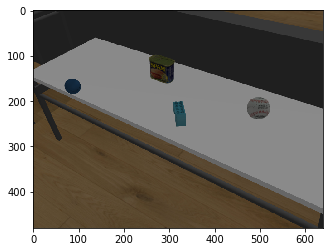

In [30]:
plt.imshow(rgbd.get_image())

('Plane', 0, 'has', 5, 'objects')
('Plane', 1, 'has', 2, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.31608732, -0.34043993,  0.90988334]), array([-0.05916133, -0.19799521,  0.96755584]), array([-0.37246006, -0.12871588,  0.91625378]), array([ 0.25752004, -0.03795994,  0.79782117]), array([ 0.00647471, -0.02153574,  0.81584384]), array([0.14796345, 0.19717462, 0.78824498]), array([0.28169959, 0.3923939 , 0.99786044])]
('images[]', 1)
('images[]', 2)
('images[]', 3)
('images[]', 4)
('images[]', 6)
1
2
3
4


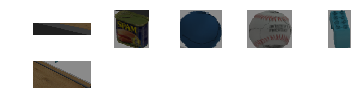

In [31]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats, 'tmc_plane_segmentation')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'tmc_plane_segmentation', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_tmc',pp ,(.05,.1,.3))
    print i




In [41]:
gaze_point(1.16,1.6,.4)  #center of table 1' ish
#gaze_point(-.03,1.6,0.7)  #center of table 2' ish


('i am at', [0.9519317807131412, 0.8814299898778544, 1.2037980323242414], 27.99712998707833)
('gaze goal', 1.16, 1.6, 0.4)
('relative to robot', (-0.2080682192868587, -0.7185700101221457, -106.14883467969342))


True

('cX,cY', 571, 414)
[0.47161204 0.25049478 1.377497  ]
('cX,cY', 272, 222)
[-0.09468546 -0.03472062  1.0935245 ]
('cX,cY', 167, 173)
[-0.32235578 -0.14078476  1.1760631 ]
('cX,cY', 358, 152)
[ 0.08552222 -0.19464171  1.2320901 ]
('cX,cY', 123, 15)
[-0.58156234 -0.84674054  2.1382694 ]
('images[]', 0)
('images[]', 1)
('images[]', 2)
('images[]', 3)
0
1
2
3


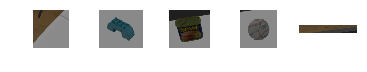

In [42]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'kmeans')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'kmeans', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_kmeans',pp ,(0.3,.1,.05))
    print i


In [43]:
whole_body.get_current_pose()

header: 
  seq: 0
  stamp: 
    secs: 278
    nsecs: 416000000
  frame_id: "odom"
pose: 
  position: 
    x: 1.31234757659
    y: 1.10893481931
    z: 0.671870232643
  orientation: 
    x: 0.999975867087
    y: -0.00679866510589
    z: -0.00139624340631
    w: 0.000306430890037

In [44]:
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()


True

In [45]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
tf.transformations.euler_from_quaternion(o)
rotated= tf.transformations.quaternion_from_euler(-np.pi,0,np.pi)

In [46]:

wbt= np_2_pose(p,rotated)

wbt.header.frame_id='odom'

whole_body.set_pose_target(wbt)
plan=whole_body.plan()
if len(plan.joint_trajectory.points)!=0:
    succ=whole_body.go()
    print 'scc'
else:
    print 'plan failed'


scc


In [37]:
#publish_scene()

clear_octo_client.call()
scene.remove_world_object()

In [47]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
r=tf.transformations.quaternion_from_euler(0,np.pi*0.5,0)#grasp from above
rotated=tf.transformations.quaternion_multiply(r,o)


In [48]:
target_name= 'Object1_kmeans'
target_pose =scene.get_object_poses([target_name])

tpos = np.asarray((target_pose[target_name].position.x,
                   target_pose[target_name].position.y,
                   target_pose[target_name].position.z,
                  ))

In [49]:
target_pose

{'Object1_kmeans': position: 
   x: 1.0827720035
   y: 1.71022719966
   z: 0.416188258779
 orientation: 
   x: 0.293313279218
   y: 0.246572394082
   z: 0.601762946833
   w: 0.700750119893}

In [50]:
p,tpos
scene.remove_world_object(target_name)

In [51]:
tpos[2]+=.08

wbt= np_2_pose(tpos,o)

wbt.header.frame_id='odom'

whole_body.set_pose_target(wbt)
plan=whole_body.plan()
if len(plan.joint_trajectory.points)!=0:
    succ=whole_body.go()
    print 'scc'
else:
    print 'plan failed'


plan failed


In [52]:

clear_octo_client.call()
scene.remove_world_object()


In [53]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
p,  tf.transformations.euler_from_quaternion(o)
rotated=np.asarray(tf.transformations.quaternion_from_euler(np.pi,0,np.pi*0.5))

In [54]:
len(plan.joint_trajectory.points)

0

In [55]:
if len(plan.joint_trajectory.points)!=0:
    whole_body.go()

In [56]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
tf.transformations.euler_from_quaternion(o)
rotated= tf.transformations.quaternion_from_euler(.12*np.pi,0,np.pi)

In [57]:
arm.set_named_target('go')
arm.go()

True

In [58]:
wbt= np_2_pose(p,rotated)

wbt.header.frame_id='odom'

whole_body.set_pose_target(wbt)
plan=whole_body.plan()
if len(plan.joint_trajectory.points)!=0:
    succ=whole_body.go()
    print 'scc'
else:
    print 'plan failed'


plan failed


In [59]:
gaze_point(1.16,1.8,.4)  #center of table 1' ish


('i am at', [0.5418375214009735, 0.4562422372463622, 0.9672481213005929], 27.10602925519354)
('gaze goal', 1.16, 1.8, 0.4)
('relative to robot', (-0.6181624785990264, -1.343757762753638, -114.7036234929498))


True

('cX,cY', 145, 290)
[-0.419272    0.12318692  1.3421482 ]
('cX,cY', 299, 253)
[-0.05634838  0.03472693  1.5239294 ]
('cX,cY', 217, 234)
[-0.29310173 -0.01687726  1.5947337 ]
('cX,cY', 350, 221)
[ 0.09781139 -0.06089326  1.7471932 ]
('cX,cY', 273, 72)
[-0.31901804 -1.4137576   4.498993  ]
('images[]', 1)
('images[]', 2)
('images[]', 3)
1
2
3


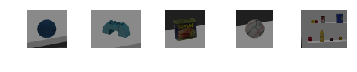

In [60]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'odom','Table_Object'+str(i), rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "odom"
    scene.add_box('Object'+str(i),pp ,(.3,.1,.01))
    print i


In [61]:
obj_ind=1
obj_key='Object'+str(obj_ind)
target_pose =scene.get_object_poses([obj_key])
tpos = np.asarray((target_pose[obj_key].position.x,
                   target_pose[obj_key].position.y,
                   target_pose[obj_key].position.z,
                  ))
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)

r=tf.transformations.quaternion_from_euler(0,np.pi*.5,0) #grasp from above
rotated=tf.transformations.quaternion_multiply(r,o)


In [62]:
tpos[2]+=.1

wbt= np_2_pose(tpos,rotated)
clear_octo_client.call()
scene.remove_world_object()
wbt
wbt.header.frame_id='odom'
whole_body.set_pose_target(wbt)
plan=whole_body.plan()

In [63]:
if len(plan.joint_trajectory.points)!=0:
    whole_body.go()
else:
    print('failed ')

failed 


In [64]:
tpos

array([1.09663097, 1.73958953, 0.50379962])

In [65]:
p

array([0.74072914, 0.39234493, 0.67295763])

In [66]:
wbp

header: 
  seq: 0
  stamp: 
    secs: 345
    nsecs:  62000000
  frame_id: "odom"
pose: 
  position: 
    x: 0.740729135104
    y: 0.392344931987
    z: 0.672957633667
  orientation: 
    x: 0.607414756452
    y: -0.362307867011
    z: 0.607179545214
    w: 0.362095737368

In [67]:
p,tpos

(array([0.74072914, 0.39234493, 0.67295763]),
 array([1.09663097, 1.73958953, 0.50379962]))

In [68]:
#1.5*p-.5*tpos
dif=tpos-p

In [69]:
np.rad2deg(np.arctan2(dif[1],dif[0]))

75.20220784285901

In [70]:
np.rad2deg(whole_body.get_current_joint_values()[2])

28.494775881360912

In [71]:
p,tpos


(array([0.74072914, 0.39234493, 0.67295763]),
 array([1.09663097, 1.73958953, 0.50379962]))

In [72]:
dif=tpos-p
whole_body.get_current_joint_values()[2]-np.arctan2(dif[1],dif[0])

-0.8150679755779903

In [73]:
move_base(whole_body.get_current_joint_values()[0],whole_body.get_current_joint_values()[1],whole_body.get_current_joint_values()[2]-np.arctan2(dif[1],dif[0]))

3

In [74]:
def face_point(tpos):
    wbp=whole_body.get_current_pose()
    p, o =pose_2_np(wbp)
    dif=tpos-p
    move_base(whole_body.get_current_joint_values()[0],whole_body.get_current_joint_values()[1],whole_body.get_current_joint_values()[2]-np.arctan2(dif[1],dif[0]))
    

In [ ]:
face_point (tpos)

In [ ]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
dif=tpos-p
move_base(whole_body.get_current_joint_values()[0],whole_body.get_current_joint_values()[1],whole_body.get_current_joint_values()[2]-np.arctan2(dif[1],dif[0]))


In [ ]:
p, tpos

In [ ]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
dif=tpos-p

In [ ]:
dif

In [ ]:
np.arctan2(dif[1],dif[0])

In [ ]:
tf.transformations.euler_from_quaternion(o)

In [ ]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
tf.transformations.euler_from_quaternion(o)

In [ ]:
whole_body.get_current_joint_values()[2]

In [192]:
move_base( p[0],p[1],np.arctan2(dif[1],dif[0]))

3

In [193]:
wbp=whole_body.get_current_pose()
p, o =pose_2_np(wbp)
dif=tpos-p

In [195]:
p, tpos

(array([2.10485314, 1.23697572, 0.67300865]), array([1., 1., 1.]))

In [199]:
def face_point(tpos):
    wbp=whole_body.get_current_pose()
    p, o =pose_2_np(wbp)
    dif=tpos-p
    np.arctan2(dif[1],dif[0])
    move_base( p[0],p[1],np.arctan2(dif[1],dif[0]))

In [ ]:
face_point()